In [1]:
import pandas as pd
import numpy as np
import time
from matplotlib import pyplot as plt
import datetime as dt
import talib
from tqdm import tqdm
import colorama as col
from bt import *
from sklearn.preprocessing import MinMaxScaler
import pycaret
from pycaret.classification import *

print('PyCaret: %s' % pycaret.__version__)

print('Ready')

Importing Librairies...
PyCaret: 2.2.0
Ready


In [2]:
%%time
##### Chargement de la base
base = pd.read_csv('Base_Clean/EURUSDm5.csv')

##### On fixe la date en index sous forme de Timestamp
base.set_index(pd.to_datetime(base.Date),drop=True,inplace=True)

###### On drop les colonnes inutiles
base = base.drop(['Date','Total'],axis=1)

##### On enlève les jours correspondant au samedi et au dimanche
base['WE'] = np.where(((base.index.weekday == 5) | (base.index.weekday == 6)),None,base.index.weekday)
base = base.dropna()
base = base.drop(['WE'],axis=1)


CPU times: user 1.96 s, sys: 286 ms, total: 2.24 s
Wall time: 2.29 s


In [3]:
base.index[0],base.index[-1]

(Timestamp('2010-11-23 00:00:00'), Timestamp('2020-11-23 15:40:00'))

In [4]:
%%time
_year_bottom = pd.to_datetime('2011-01-01 16:00:00')
_year_top = pd.to_datetime('2015-12-31 16:00:00') #2020-11-23 16:00:00

df = base[(base.index>=_year_bottom)&(base.index<=_year_top)]

CPU times: user 25.7 ms, sys: 17.9 ms, total: 43.5 ms
Wall time: 47.3 ms


In [5]:
df['HiWin'] = df.High.rolling(10).max()
df['LoWin'] = df.Low.rolling(10).min()
df['JyssOscUp'] = ((df.HiWin-df.HiWin.shift(2))/df.HiWin.shift(2))*1000
df['JyssOscUpSD'] = df.JyssOscUp.rolling(20).std()
df['JyssOscDwn'] = ((df.LoWin-df.LoWin.shift(2))/df.LoWin.shift(2))*1000
df['JyssOscDwnSD'] = df.JyssOscDwn.rolling(20).std()
df['TriggerBull'] = (df.HiWin - df.HiWin.shift(2)) * 1000
df['TriggerBear'] = (df.LoWin - df.LoWin.shift(2)) * 1000
df['Trigger'] = np.where((df.LoWin - df.LoWin.shift(9) == 0),1,np.where((df.HiWin - df.HiWin.shift(9) == 0 ),1,0))

In [6]:
df['Signal'] = np.where(\
    ((df.Close <= 1.01*df.LoWin)&(df.JyssOscUp <= -4*df.JyssOscUpSD)),1,\
        np.where(\
            ((df.Close >= 0.99*df.HiWin)&(df.JyssOscDwn >= 4*df.JyssOscDwnSD)),-1,0)
)
df['SignalClose'] = np.where(\
    ((df.Close >= 0.99*df.HiWin)&(df.JyssOscDwn <= -3*df.JyssOscDwnSD)),1,\
        np.where(\
            ((df.Close <= 1.01*df.LoWin)&(df.JyssOscUp >= 3*df.JyssOscUpSD)),-1,0)
)

In [7]:
_nb_bougie_exit = 96000000
_trigger_reengage = 0
_trigger_target = 0
_trigger_invers = 1
_trigger_sl = 0
_verbose = 0
_cash_ini = 200000
_rate = 1
x = 'EUR/USD'
_target = 0.006
_exposure = 3
_size = 50000
_sl = 0.002
TRACKER = bt(df,_year_bottom,_year_top,_nb_bougie_exit,_trigger_reengage,_trigger_target,_trigger_invers,_trigger_sl,_verbose,_cash_ini,\
        _rate,x,_target,_exposure,_size,_sl)

Librairies imported

Début des opérations horodatée à 2020-12-18 10:57:35.349829

Chargement de la nouvelle base


 Le rate du ticker EUR/USD est à  1 
Bases chargées
TETEL process effectué
 ENTERING THE BACKTEST 
100%|██████████| 369102/369102 [00:33<00:00, 11011.91it/s]
 Pour le ticker  EUR/USD 
 
Les gains faramineux s'élèvent à : $  6586.0 !. En  826   transactions.
 
Nbre de winners : 497 
 
Nbre de loosers : 329 
Temps d'excution du BT 0:00:40.149811
 EUR/USD  results 
 Tested Period 2011-01-01 16:00:00  à 2015-12-31 16:00:00 
 Total Number of trades 826 
Started Cash : 50000
P&L  in currency:  6586.0$ 
P&L in %:  3.29% 
Average trade duration 312.57
# Winners  497.0
# Loosers  329.0
Cumulated gains 112227.5
Cumulated losses -105641.5
 PROFIT FACTOR :  1.06 
 Winners Ratio : 60.17 % 
Average Winners 225.81
% Average Winners 0.11
Average Loosers -321.1
% Average Loosers -0.16
Average pnl 7.97
% Average pnl 0.0
Number of opened trades 826
Number of closed trades 826
Max Exposure 1 

In [8]:
len(TRACKER)

497

In [9]:
%%time
scaler = MinMaxScaler((0,1))
df_2 = df.copy()
df_2['RSI2'] = talib.RSI(df_2.Close,timeperiod=2)
df_2['MMA200'] = talib.EMA(df_2.Close,timeperiod=200)
upper, middle, lower = talib.BBANDS(df_2.Close, timeperiod=10, nbdevup=2, nbdevdn=2)
df_2['SBVol'] = upper - lower
df_2['MMA55'] = talib.EMA(df_2.Close,timeperiod=55)
df_2['MMA80'] = talib.EMA(df_2.Close,timeperiod=80)
df_2['RSI14'] = talib.RSI(df_2.Close,timeperiod=14)

ar_up,ar_low = talib.AROON(df_2.High,df_2.Low,10)
df_2['AR_HI'] = ar_up
df_2['AR_LO'] = ar_low
df_2['AROON'] = ar_up - ar_low

df_2 = df_2.drop(['SignalClose'],axis=1)

df_2.rename(columns = {'Signal':'SigO4bt'}, inplace = True)
SIGNAL = []
SIGNAL = [1 if ((df_2['SigO4bt'][i] != 0) & (df_2.index[i] in TRACKER)) else 0 for i in tqdm(range(len(df_2)))]
df_2['Signal'] = SIGNAL

df_2 = df_2.dropna()

df_2 = df_2.sort_index(axis=1)


100%|██████████| 369132/369132 [00:20<00:00, 18299.29it/s]
CPU times: user 20.2 s, sys: 386 ms, total: 20.6 s
Wall time: 20.7 s


In [10]:
%%time
#### 73% Prec seed 53
featuring = setup(
    data=df_2[df_2.SigO4bt!=0].sort_index(axis=1).dropna(),
    silent = True, 
    target='Signal',
    session_id = 53,
    preprocess = False,
    train_size = 0.7,
    normalize = True, normalize_method='zscore',
    verbose=True,
    pca = True, pca_method = 'linear', pca_components = 0.9,
    feature_ratio = True, 
    transformation = True,
    polynomial_features = True, polynomial_degree = 3, polynomial_threshold = 0.7,
    trigonometry_features = True,
    feature_selection = True, feature_selection_threshold = 0.5, feature_selection_method='classic',
    feature_interaction = True, interaction_threshold = 0.9,
    remove_multicollinearity = True, multicollinearity_threshold = 0.8,
    data_split_shuffle = True, 
    ignore_low_variance = False,
    )

,Description,Value
0,session_id,53
1,Target,Signal
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(2675, 34)"
5,Missing Values,False
6,Numeric Features,31
7,Categorical Features,2
8,Transformed Train Set,"(1872, 33)"
9,Transformed Test Set,"(803, 33)"


CPU times: user 1.11 s, sys: 192 ms, total: 1.3 s
Wall time: 1.56 s


In [11]:
%%time
best = compare_models(sort='Prec.',fold=5,cross_validation=True,turbo=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.8141,0.5087,0.0143,0.7333,0.0279,0.0188,0.0784,4.4800
gbc,Gradient Boosting Classifier,0.8066,0.5125,0.0258,0.2643,0.0470,0.0174,0.0309,0.4180
qda,Quadratic Discriminant Analysis,0.7067,0.5257,0.2470,0.2275,0.2218,0.0540,0.0559,0.0280
knn,K Neighbors Classifier,0.7863,0.5220,0.0487,0.2018,0.0782,0.0059,0.0081,0.4980
dt,Decision Tree Classifier,0.6902,0.5081,0.2178,0.1985,0.2075,0.0156,0.0157,0.0480
et,Extra Trees Classifier,0.7826,0.5089,0.0430,0.1708,0.0684,-0.0069,-0.0090,0.2620
ada,Ada Boost Classifier,0.8066,0.5070,0.0086,0.1667,0.0162,-0.0027,-0.0004,0.2360
nb,Naive Bayes,0.7121,0.5028,0.1291,0.1580,0.1415,-0.0283,-0.0288,0.0280
rf,Random Forest Classifier,0.8040,0.5003,0.0144,0.1331,0.0256,-0.0013,-0.0079,0.3360
svm,SVM - Linear Kernel,0.6150,0.0000,0.2726,0.1015,0.1477,-0.0202,-0.0263,0.0300


CPU times: user 29.7 s, sys: 2.13 s, total: 31.9 s
Wall time: 49.1 s


In [10]:
%%time
for i in range(100,125):
    featuring = setup(
        data=df_2[df_2.SigO4bt!=0].sort_index(axis=1).dropna(),
        silent = True, 
        target='Signal',
        session_id = i,
        preprocess = False,
        train_size = 0.7,
        normalize = True, normalize_method='zscore',
        verbose=True,
        pca = True, pca_method = 'linear', pca_components = 0.9,
        feature_ratio = True, 
        transformation = True,
        polynomial_features = True, polynomial_degree = 3, polynomial_threshold = 0.7,
        trigonometry_features = True,
        feature_selection = True, feature_selection_threshold = 0.5, feature_selection_method='classic',
        feature_interaction = True, interaction_threshold = 0.9,
        remove_multicollinearity = True, multicollinearity_threshold = 0.8,
        data_split_shuffle = True, 
        ignore_low_variance = False,
        )
    print('\n Rang',i,'\n',compare_models(sort='Prec.',fold=5,cross_validation=True,turbo=True))
    time.sleep(1)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7730,0.5268,0.0836,0.2387,0.1224,0.0263,0.0314,0.0720
rf,Random Forest Classifier,0.8008,0.4776,0.0167,0.2250,0.0309,0.0054,0.0111,0.3380
dt,Decision Tree Classifier,0.6896,0.5096,0.2175,0.2035,0.2096,0.0172,0.0174,0.0400
et,Extra Trees Classifier,0.7767,0.4917,0.0446,0.2000,0.0718,-0.0051,-0.0022,0.2500
nb,Naive Bayes,0.7495,0.4909,0.0782,0.1662,0.1050,-0.0169,-0.0191,0.0300
qda,Quadratic Discriminant Analysis,0.6034,0.5114,0.3541,0.1541,0.1900,0.0009,-0.0001,0.0220
catboost,CatBoost Classifier,0.8077,0.4888,0.0028,0.1000,0.0054,0.0023,0.0064,5.1740
svm,SVM - Linear Kernel,0.6458,0.0000,0.2000,0.0930,0.1218,-0.0355,-0.0416,0.0220
ada,Ada Boost Classifier,0.7991,0.4684,0.0083,0.0733,0.0147,-0.0076,-0.0221,0.2020
gbc,Gradient Boosting Classifier,0.7975,0.4903,0.0028,0.0250,0.0051,-0.0172,-0.0425,0.4040



 Rang 124 
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')
CPU times: user 5min 14s, sys: 17.7 s, total: 5min 32s
Wall time: 20min 46s


In [60]:
%%time
model_tuned = tune_model(best,fold=5,optimize='Prec.',n_iter=30,search_library='scikit-learn',search_algorithm='random',choose_better=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8027,0.4595,0.0000,0.0000,0.0000,-0.0156,-0.0434
1,0.8133,0.5025,0.0141,1.0000,0.0278,0.0226,0.1070
2,0.8128,0.4154,0.0141,1.0000,0.0278,0.0226,0.1070
3,0.8182,0.5245,0.0286,1.0000,0.0556,0.0456,0.1528
4,0.8155,0.5077,0.0143,1.0000,0.0282,0.0230,0.1079
Mean,0.8125,0.4819,0.0142,0.8000,0.0279,0.0197,0.0863
SD,0.0053,0.0396,0.0090,0.4000,0.0176,0.0197,0.0672


CPU times: user 1min 4s, sys: 3.94 s, total: 1min 8s
Wall time: 4min 56s


In [38]:
model_tuned

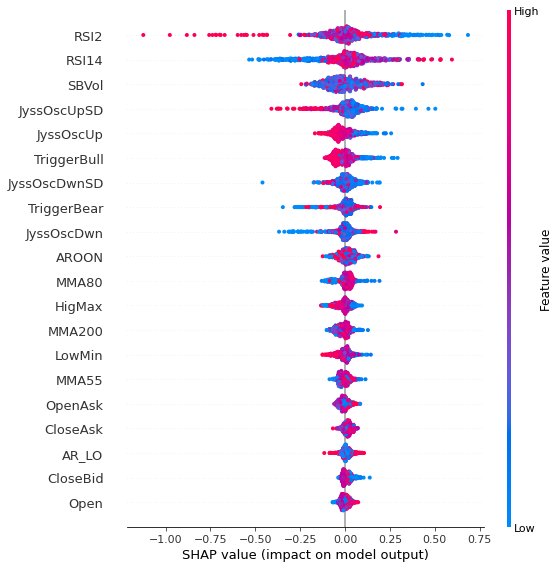

CPU times: user 7.21 s, sys: 286 ms, total: 7.5 s
Wall time: 3.22 s


In [12]:
%%time
interpret_model(best)

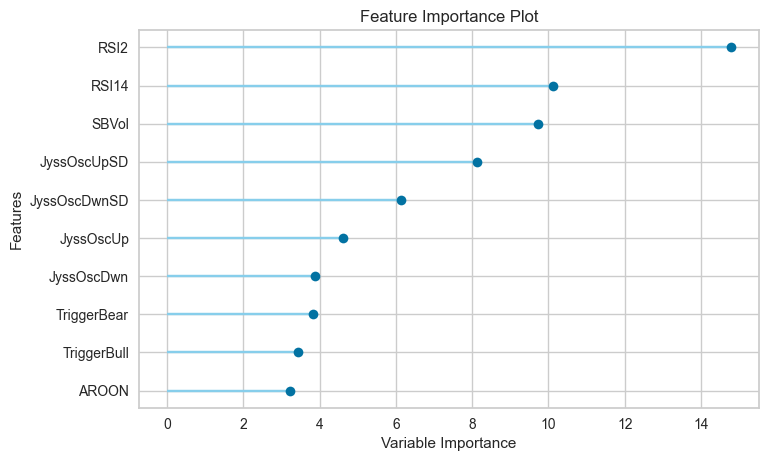

In [13]:
plot_model(best, plot = 'feature')

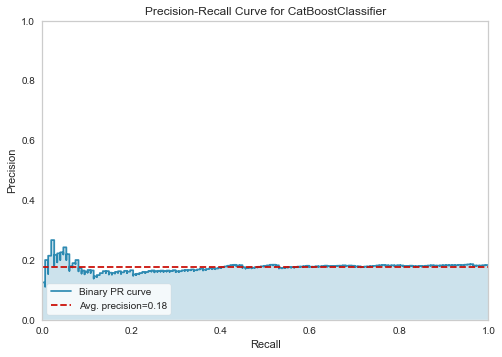

In [14]:
plot_model(best,'pr')

In [138]:

from sklearn.linear_model import RidgeClassifier
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt
from numpy import sqrt
from numpy import argmax
import colorama as col
from collections import Counter
import joblib

import pyttsx3
engine = pyttsx3.init()

import configparser
config = configparser.ConfigParser()

engine.say("Ridge Classification")
engine.runAndWait()


def modelize(df,x,_model,_verbose=0):
    

    print(col.Fore.BLUE,'RidgeClassifier pour',col.Fore.YELLOW,x,col.Style.RESET_ALL)

    
    ### Isolation de la partie out of sample ####

    #df.iloc[-int(len(df) * 0.2):,:].to_csv(_path5+x.replace('/','')+_period1+'.csv')
    

    Xb = df.sort_index(axis=1).copy()
    try:
        Xb = Xb.set_index(Xb.Date, drop =True)
    except:
        pass
    yb = Xb['Signal']
    Xb = Xb.loc[:, Xb.columns != 'Signal']
    Xb = Xb.sort_index(axis=1)
    
    # summarize class distribution
    counterb = Counter(yb)
    
    print('Signaux achat',counterb)
    #print(counterb[-1],counterb[1])

    if counterb[1] > 2 and counterb[0] > 2:
    
        # split into train/test sets with same class ratio
        trainXb, testXb, trainyb, testyb = train_test_split(Xb, yb, test_size=0.7, stratify=yb)
        # define model
        #model = LogisticRegression(solver='liblinear', class_weight='balanced')
        model = RidgeClassifier(
                                alpha=0.5, 
                                fit_intercept=False, 
                                normalize=False, 
                                copy_X=True, 
                                max_iter=1, 
                                tol=0.01, 
                                class_weight=None, 
                                solver='auto', 
                                random_state=None
                                )
        # fit model
        model.fit(trainXb, trainyb)
        # predict on test set
        yhatb = model.predict(testXb)
        # evaluate predictions
        accub = round(accuracy_score(testyb, yhatb) * 100,2)
        precb = round(precision_score(testyb, yhatb) * 100,2)
        recallb = round(recall_score(testyb, yhatb) * 100,2)
        f1b = round(f1_score(testyb, yhatb) * 100,2)

        print(col.Fore.BLUE,'Pour',col.Fore.YELLOW,x,col.Style.RESET_ALL)
        if accub > 69 and precb > 69 :
            print(col.Fore.GREEN)
        elif accub < 51 or precb < 51 :
            print(col.Fore.RED)
        else:
            print(col.Fore.YELLOW)

        print('Achat - Accuracy :' ,accub,'%')
        print('Achat - Precision :',precb,'%')
        print('Achat - Recall :', recallb,'%')
        print('Achat - F-measure: :' ,f1b,'%',col.Style.RESET_ALL)
        print('\n')
        
        print(classification_report(testyb, yhatb))
        conf_matrix = pd.DataFrame(index = ['vrais_réels','Faux_réels'])
        conf_matrix['Vrais_estimés'] = ['Vrais_positifs','Faux_positifs']
        conf_matrix['Faux_estimés'] = ['Faux_négatif','Vrais-négatifs']
        print(conf_matrix)
        print(confusion_matrix(testyb, yhatb))
        print('\n')

        savename = 'JOBLIB/ridge/Save'+x.replace('/','')+'m5.sav'
        
        # some time later...
        
        # load the model from disk
        #loaded_model = joblib.load(filename)
        #result = loaded_model.score(X_test, Y_test)
        #print(result)

        # serialize model to JOBLIB
        joblib.dump(model, savename)
        print(col.Fore.BLUE,"Joblib Model ",savename," dumped to disk",col.Style.RESET_ALL)
        
        
        precisionb, recallb, thresholdsb = precision_recall_curve(testyb, yhatb)
        # plot the roc curve for the model
        no_skillb= len(testyb[testyb==1]) / len(testyb)

        # convert to f score
        fscoreb = (2 * precisionb * recallb) / (precisionb + recallb)
        # locate the index of the largest f score
        ixb = argmax(fscoreb)
        print('Best Threshold=%f, F-Score=%.3f' % (thresholdsb[ixb], fscoreb[ixb]))


        if _verbose == 1:

            plt.ion()
            plt.figure(figsize=(12,4))
            plt.suptitle('Recall_Precision Curve pour les achats')
            plt.plot([0,1], [no_skillb,no_skillb], linestyle='--', label='No Skill')
            plt.plot(recallb, precisionb, marker='.', label='Logistic')
            plt.scatter(recallb[ixb], precisionb[ixb], marker='o', color='black', label='Best')
            # axis labels
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.legend()
            # show the plot
            plt.show()

    else:
        print(col.Fore.RED,'Not enough populated for',col.Fore.YELLOW,x,col.Style.RESET_ALL)
    return()

modelize(df_2[df_2.SigO4bt!=0].sort_index(axis=1).dropna(),'EUR/USD',0)

 RidgeClassifier pour  EUR/USD 
Signaux achat Counter({0: 2179, 1: 496})
 Pour  EUR/USD 

Achat - Accuracy : 81.47 %
Achat - Precision : 0.0 %
Achat - Recall : 0.0 %
Achat - F-measure: : 0.0 % 


              precision    recall  f1-score   support

           0       0.81      1.00      0.90      1526
           1       0.00      0.00      0.00       347

    accuracy                           0.81      1873
   macro avg       0.41      0.50      0.45      1873
weighted avg       0.66      0.81      0.73      1873

              Vrais_estimés    Faux_estimés
vrais_réels  Vrais_positifs    Faux_négatif
Faux_réels    Faux_positifs  Vrais-négatifs
[[1526    0]
 [ 347    0]]


 Joblib Model  JOBLIB/ridge/SaveEURUSDm5.sav  dumped to disk 
Best Threshold=0.000000, F-Score=0.313


()

array([0, 0, 0, ..., 0, 0, 0])

In [16]:
%%time

#loaded_model = joblib.load('JOBLIB/ridge/Save'+x.replace('/','')+'m5.sav')

_year_bottom = pd.to_datetime('2016-01-01 16:00:00')
_year_top = pd.to_datetime('2020-11-23 16:00:00') #2020-11-23 16:00:00

df_oos = base[(base.index>=_year_bottom)&(base.index<=_year_top)]

df_oos['HiWin'] = df_oos.High.rolling(10).max()
df_oos['LoWin'] = df_oos.Low.rolling(10).min()
df_oos['JyssOscUp'] = ((df_oos.HiWin - df_oos.HiWin.shift(2)) / df_oos.HiWin.shift(2))*1000
df_oos['JyssOscUpSD'] = df_oos.JyssOscUp.rolling(20).std()
df_oos['JyssOscDwn'] = ((df_oos.LoWin - df_oos.LoWin.shift(2)) / df_oos.LoWin.shift(2))*1000
df_oos['JyssOscDwnSD'] = df_oos.JyssOscDwn.rolling(20).std()
df_oos['TriggerBull'] = (df_oos.HiWin - df_oos.HiWin.shift(2)) * 1000
df_oos['TriggerBear'] = (df_oos.LoWin - df_oos.LoWin.shift(2)) * 1000
df_oos['Trigger'] = np.where((df_oos.LoWin - df_oos.LoWin.shift(9) == 0),1,np.where((df_oos.HiWin - df_oos.HiWin.shift(9) == 0 ),1,0))
df_oos['RSI2'] = talib.RSI(df_oos.Close,timeperiod=2)
df_oos['MMA200'] = talib.EMA(df_oos.Close,timeperiod=200)
upper, middle, lower = talib.BBANDS(df_oos.Close, timeperiod=10, nbdevup=2, nbdevdn=2)
df_oos['SBVol'] = upper - lower

df_oos['MMA55'] = talib.EMA(df_oos.Close,timeperiod=55)
df_oos['MMA80'] = talib.EMA(df_oos.Close,timeperiod=80)
df_oos['RSI14'] = talib.RSI(df_oos.Close,timeperiod=14)

ar_up,ar_low = talib.AROON(df_oos.High,df_oos.Low,10)
df_oos['AR_HI'] = ar_up
df_oos['AR_LO'] = ar_low
df_oos['AROON'] = ar_up - ar_low


df_oos['Signal'] = np.where(\
    ((df_oos.Close <= 1.01 * df_oos.LoWin) & (df_oos.JyssOscUp <= -4*df_oos.JyssOscUpSD)),1,\
        np.where(\
            ((df_oos.Close >= 0.99 * df_oos.HiWin) & (df_oos.JyssOscDwn >= 4*df_oos.JyssOscDwnSD)),-1,0)
)
df_oos['SignalClose'] = np.where(\
    ((df_oos.Close >= 0.99 * df_oos.HiWin) & (df_oos.JyssOscDwn <= -3 * df_oos.JyssOscDwnSD)),1,\
        np.where(\
            ((df_oos.Close <= 1.01 * df_oos.LoWin) & (df_oos.JyssOscUp >= 3 * df_oos.JyssOscUpSD)),-1,0)
)


df_oos = df_oos.drop(['SignalClose'],axis=1)
df_oos.rename(columns = {'Signal':'SigO4bt'}, inplace = True)


df_oos = df_oos.dropna()
df_oos = df_oos.sort_index(axis=1)


#df_oos['Signal_hat'] = loaded_model.predict(df_oos)
df_oos['Signal_hat'] = best.predict(df_oos.sort_index(axis=1).dropna())
df_oos['Signal'] = np.where(
                            ((df_oos.SigO4bt == 1)&(df_oos.Signal_hat==1)),1,\
                                np.where(((df_oos.SigO4bt == -1)&(df_oos.Signal_hat==1)),-1,0)


)

CPU times: user 1.36 s, sys: 275 ms, total: 1.64 s
Wall time: 918 ms


In [17]:
_nb_bougie_exit = 6
_trigger_reengage = 0
_trigger_target = 0
_trigger_invers = 0
_trigger_sl = 1
_verbose = 0
_cash_ini = 200000
_rate = 1
x = 'EUR/USD'
_target = 0.004
_exposure = 10
_size = 50000
_sl = 0.002

bt(df_oos,_year_bottom,_year_top,_nb_bougie_exit,_trigger_reengage,_trigger_target,_trigger_invers,_trigger_sl,_verbose,_cash_ini,\
        _rate,x,_target,_exposure,_size,_sl)

Librairies imported

Début des opérations horodatée à 2020-12-18 11:09:13.375940

Chargement de la nouvelle base


 Le rate du ticker EUR/USD est à  1 
Bases chargées
TETEL process effectué
 ENTERING THE BACKTEST 
100%|██████████| 360005/360005 [00:07<00:00, 47288.43it/s]
 Pour le ticker  EUR/USD 
 
Les gains faramineux s'élèvent à : $  -369.5 !. En  22   transactions.
 
Nbre de winners : 8 
 
Nbre de loosers : 14 
Temps d'excution du BT 0:00:14.165457
 EUR/USD  results 
 Tested Period 2016-01-01 16:00:00  à 2020-11-23 16:00:00 
 Total Number of trades 22 
Started Cash : 50000
P&L in currency:  -369.5$ 
P&L in %:  -0.18% 
Average trade duration 5.71
# Winners  8.0
# Loosers  14.0
Cumulated gains 440.0
Cumulated losses -809.5
 PROFIT FACTOR :  0.54 
 Winners Ratio : 36.36 % 
Average Winners 55.0
% Average Winners 0.03
Average Loosers -57.82
% Average Loosers -0.03
Average pnl -16.8
% Average pnl -0.01
Number of opened trades 22
Number of closed trades 22
Max Exposure 1 x  50000 =  50000

[Timestamp('2016-03-17 23:45:00'),
 Timestamp('2016-06-13 12:20:00'),
 Timestamp('2016-11-22 18:05:00'),
 Timestamp('2016-12-12 18:45:00'),
 Timestamp('2016-12-15 02:55:00'),
 Timestamp('2016-12-19 21:20:00'),
 Timestamp('2017-01-03 09:50:00'),
 Timestamp('2017-01-16 00:45:00'),
 Timestamp('2019-03-22 11:20:00'),
 Timestamp('2019-03-28 10:40:00')]

In [ ]:
len(df_oos[df_oos.Signal==0])

In [ ]:
df.sort_index(axis=1).info()